# 🎨 Conditional Image Generation with cGANs

While standard GANs learn to generate realistic images from a dataset, they offer no control over *what kind* of image is generated. The output is entirely random.

**Conditional GANs (cGANs)** solve this by introducing a **condition** (`y`) to the generation process. This condition, which could be a class label, text, or a set of attributes, is fed into both the generator and the discriminator.

- 👨‍🎨 **The Conditional Generator** learns to create 'fake' images that not only look real but also match the given condition `y`.
- 🕵️‍♂️ **The Conditional Discriminator** learns to determine if an image is real *and* if it matches its corresponding condition `y`.

This allows us to direct the image generation process. For this notebook, we'll use the CelebA dataset and condition the GAN on facial attributes like 'Smiling', 'Male', and 'Blond_Hair' to generate specific types of faces.

![GANs vs CGANs Image](https://i.imgur.com/PNRcz5N.png)
<p align = "center">
Fig.1 - GAN vs. CGAN
(<a href="https://itchef.ru/articles/341494/">
source
</a>)
</p>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import pandas as pd

from torchvision.transforms import Compose, ToTensor, Lambda, Resize, Normalize
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
import numpy as np
from PIL import Image
import kagglehub
import os

## ⚙️ Hyperparameters and Setup
Here we define the key parameters for our cGAN model and training process.

In [2]:
EPOCHS = 5 # Training for longer can improve results, I found 150 the best for this task.
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
Z = 100 # Latent dimension
IMAGE_SIZE = 64
NUM_ATTRIBUTES = 5 # Number of conditional attributes

## 🖼️ Loading the CelebA Dataset with Attributes

We'll use the CelebA (CelebFaces Attributes) dataset, which is perfect for this task because it includes a large collection of celebrity faces, each annotated with 40 binary attributes.

### 🔹 **Dataset Details:**
- **Source**: `jessicali9530/celeba-dataset` from Kaggle
- **Content**: Over 200,000 celebrity images with attribute annotations.
- **Conditioning**: We will select 5 key attributes to condition our model on: `Male`, `Smiling`, `Young`, `Eyeglasses`, and `Blond_Hair`.
- **Preprocessing**: Images are resized to `64x64` and pixel values are normalized to `[-1, 1]` to match the generator's `Tanh` output.

In [3]:
# Define transforms to resize and normalize the images
transform_steps = Compose([
    Resize((IMAGE_SIZE, IMAGE_SIZE)),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
])

In [4]:
# Custom dataset class for CelebA faces and attributes
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None, max_samples=None):
        self.root_dir = root_dir
        self.transform = transform

        # Load the main attributes file
        attr_file = os.path.join(root_dir, 'list_attr_celeba.csv')
        self.attr_df = pd.read_csv(attr_file)

        # Define the 5 key attributes we'll use for conditioning
        self.selected_attributes = ['Male', 'Smiling', 'Young', 'Eyeglasses', 'Blond_Hair']

        # The image directory is nested, so we define the full path
        self.img_dir = os.path.join(root_dir, 'img_align_celeba', 'img_align_celeba')

        self.image_files = []
        self.attributes = []

        count = 0
        # Iterate through the attribute file to get image names and their labels
        for idx, row in tqdm(self.attr_df.iterrows(), total=len(self.attr_df)):
            if max_samples and count >= max_samples:
                break

            img_filename = row['image_id']
            img_path = os.path.join(self.img_dir, img_filename)

            # Only add the file if it actually exists
            if os.path.exists(img_path):
                self.image_files.append(img_path)
                # The attributes are stored as -1 and 1. We convert them to 0 and 1.
                attrs = [(row[attr] + 1) // 2 for attr in self.selected_attributes]
                self.attributes.append(attrs)
                count += 1


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        # Get the attributes and convert them to a tensor
        attributes = torch.tensor(self.attributes[idx], dtype=torch.long)

        # Open the image and convert to RGB
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Return both the image and its corresponding attributes
        return image, attributes

In [5]:
# Download the CelebA dataset from Kaggle
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

# Create the dataset object. We use a subset for faster training.
celeba_dataset = CelebADataset(root_dir=path, transform=transform_steps, max_samples=40000)
attribute_names = celeba_dataset.selected_attributes

print(f"\nDataset size: {len(celeba_dataset)}")
print(f"Selected attributes: {attribute_names}")

 20%|█▉        | 40000/202599 [01:13<04:57, 547.46it/s]



Dataset size: 40000
Selected attributes: ['Male', 'Smiling', 'Young', 'Eyeglasses', 'Blond_Hair']


In [6]:
# Create the DataLoader
train_dataloader = DataLoader(celeba_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

### 🔹 Visualizing the Data
Let's look at some examples from the dataset to see the images and their associated attributes.

In [7]:
# Helper function to format the attribute tensor into a readable string for plotting
def format_attributes(attrs):
    """Convert attribute tensor to readable string"""
    attr_str = []
    for i, attr in enumerate(attrs):
        if attr == 1:
            attr_str.append(attribute_names[i])
    return ", ".join(attr_str) if attr_str else "None"

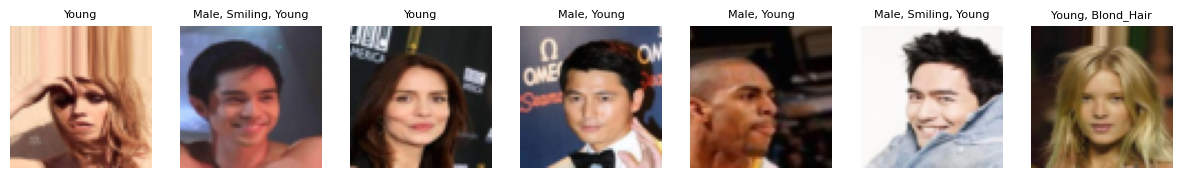

In [8]:
# Visualizing some sample images
figure = plt.figure(figsize=(15, 5))
cols, rows = 7, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(celeba_dataset), size=(1,)).item()
    img, attrs = celeba_dataset[sample_idx]
    # De-normalize from [-1,1] to [0,1] for display
    img_display = (img + 1) / 2
    figure.add_subplot(rows, cols, i)
    plt.title(format_attributes(attrs), fontsize=8)
    plt.axis("off")
    plt.imshow(img_display.permute((1,2,0)))
plt.show()

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


## Building the Conditional GAN (cGAN) Models

Our cGAN consists of two neural networks. The key difference from a standard GAN is that both networks now take the conditional attributes as an additional input. We will follow best practices from the DCGAN paper to stabilize training:

- **Weight Initialization**: Initialize weights from a Normal distribution with `mean=0`, `stdev=0.02`.
- **Activations**: Use `LeakyReLU` to prevent dying gradients.
- **Optimizer**: Use the `Adam` optimizer with `beta1=0.5`.
- **Attribute Handling**: We use `nn.Embedding` layers to convert our binary attributes (0 or 1) into dense vectors, which are easier for the network to process.

---

### 👨‍🎨 The Conditional Generator

The Generator's job is to create believable images that match a given set of attributes.

**Architecture:**
1.  **Input**: It takes two inputs: a 100-dimensional noise vector (`Z`) and a 5-element attribute vector.
2.  **Embedding**: Each of the 5 attributes is passed through its own `nn.Embedding` layer. The resulting embedding vectors are concatenated together.
3.  **Concatenation**: The latent noise vector `Z` is concatenated with the final attribute embedding vector.
4.  **Upsampling**: This combined vector is fed through a series of `ConvTranspose2d` layers to upsample it into a `64x64` color image.
5.  **Output**: A `Tanh` activation function ensures the output image pixels are in the range `[-1, 1]`, matching our input data.

---

### 🕵️‍♂️ The Conditional Discriminator

The Discriminator's job is to classify an image as real or fake, *given* a set of attributes.

**Architecture:**
1.  **Input**: It takes two inputs: a `64x64x3` image and the 5-element attribute vector.
2.  **Image Path**: The image is passed through a series of `Conv2d` layers to extract features and downsample it.
3.  **Attribute Path**: The attributes are passed through `nn.Embedding` layers, just like in the generator.
4.  **Concatenation**: The flattened feature vector from the image is concatenated with the attribute embedding vector.
5.  **Output**: This combined vector is passed through fully connected layers to produce a single `Sigmoid` output between 0 (fake or mismatched) and 1 (real and matched).

In [10]:
class Reshape(nn.Module):
    """A custom reshape layer."""
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

def weights_init(m):
    """Reinitialize model weights. GAN authors recommend them to be sampled from N(0,0.2)"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    """Generator model for CelebA with 5 attributes conditioning"""
    def __init__(self, z, num_attributes, attr_embedding_size=5):
        super(Generator, self).__init__()
        self.z = z
        self.num_attributes = num_attributes
        self.total_attr_embedding_size = num_attributes * attr_embedding_size

        # Embedding layer for each attribute (5 attributes, each with embedding size 5)
        self.condition_embeddings = nn.ModuleList([
            nn.Embedding(2, attr_embedding_size) for _ in range(num_attributes) # Binary attributes (0 or 1)
        ])

        self.gen_model = nn.Sequential(
            # Combined input: Z + attribute embeddings
            nn.Linear(z + self.total_attr_embedding_size, 512 * 4 * 4),
            nn.BatchNorm1d(512 * 4 * 4),
            nn.ReLU(True),

            Reshape((-1, 512, 4, 4)),

            # 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # 32x32 -> 64x64
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh() # Output normalized to [-1, 1]
        )

    def forward(self, x, conditions):
        conditions = conditions.long()

        # Create embeddings for each of the 5 attributes
        condition_embeds = []
        for i in range(self.num_attributes):
            embed = self.condition_embeddings[i](conditions[:, i])
            condition_embeds.append(embed)

        # Concatenate all attribute embeddings
        condition_embed = torch.cat(condition_embeds, dim=1)

        # Concatenate the noise vector 'x' and the condition embeddings
        combined_input = torch.cat([x, condition_embed], dim=1)
        return self.gen_model(combined_input)

class Discriminator(nn.Module):
    """Discriminator model for CelebA with 5 attributes conditioning"""
    def __init__(self, num_attributes, attr_embedding_size=5):
        super(Discriminator, self).__init__()
        self.num_attributes = num_attributes
        self.total_attr_embedding_size = num_attributes * attr_embedding_size

        # CNN part for image feature extraction
        self.image_feature_extractor = nn.Sequential(
            # 64x64 -> 32x32
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 32x32 -> 16x16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 16x16 -> 8x8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # 8x8 -> 4x4
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten()
        )

        # Embedding layers for the conditions
        self.condition_embeddings = nn.ModuleList([
            nn.Embedding(2, attr_embedding_size) for _ in range(num_attributes)
        ])

        # Classifier part
        self.classifier = nn.Sequential(
            # Input is flattened image features + concatenated attribute embeddings
            nn.Linear(512 * 4 * 4 + self.total_attr_embedding_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x, conditions):
        conditions = conditions.long()

        # Extract features from the image
        image_features = self.image_feature_extractor(x)

        # Create embeddings for each attribute
        condition_embeds = []
        for i in range(self.num_attributes):
            embed = self.condition_embeddings[i](conditions[:, i])
            condition_embeds.append(embed)

        # Concatenate all attribute embeddings
        condition_embed = torch.cat(condition_embeds, dim=1)

        # Concatenate image features and condition embeddings
        combined_features = torch.cat([image_features, condition_embed], dim=1)

        # Classify the combined features
        output = self.classifier(combined_features)
        return output.view(-1, 1).squeeze(1)


In [11]:
generator = Generator(z=Z, num_attributes=NUM_ATTRIBUTES)
generator.apply(weights_init)
generator.to(device)

discriminator = Discriminator(num_attributes=NUM_ATTRIBUTES)
discriminator.apply(weights_init)
discriminator.to(device)

Discriminator(
  (image_feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Flatten(start_dim=1, end_dim=-1)
  )
  (condition_embeddings): ModuleList(
    (0-4): 5 x Embedding

### Model Summaries

### 🎯 Loss Function and Optimizers

- **Loss**: We use **Binary Cross-Entropy Loss** (`BCELoss`), which is ideal for the discriminator's binary classification task (real/matched vs. fake/mismatched).
- **Optimizers**: We use the `Adam` optimizer for both networks with a `beta1` of 0.5, as recommended for stable GAN training.

In [12]:
# Defining the optimizer and loss function here
optimizer_gen = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
loss_fn = nn.BCELoss()

In [13]:
real_label = 1
fake_label = 0

In [14]:
def display_image_grid(images, labels, num_rows, num_cols, title_text):
    fig = plt.figure(figsize=(num_cols*2., num_rows*2.))
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.25)

    for ax, im, attrs in zip(grid, images, labels):
        im = torch.clamp(im, 0, 1) # Ensure values are in [0,1] for display
        ax.imshow(im.permute(1,2,0))
        ax.axis("off")
        ax.set_title(format_attributes(attrs), fontsize=7)

    fig.suptitle(title_text, fontsize=16, y=1.05)
    plt.show()

## 🚀 Training the cGAN

The training process alternates between training the discriminator and the generator. The condition `y` (our attribute vector) is passed to both networks at each step.

### Step 1: Train the Discriminator 🕵️‍♂️
The discriminator's goal is to correctly classify real images that match their conditions, and reject fake images.
$$ \nabla_{\theta_d} [\log D(x|y) + \log(1 - D(G(z|y)))] $$
- We feed it a batch of **real images** with their **real attributes** and train it to classify them as `real` (label=1).
- We then generate a batch of **fake images** using the generator (given the same real attributes) and train the discriminator to classify them as `fake` (label=0).

### Step 2: Train the Generator 👨‍🎨
The generator's goal is to fool the discriminator into thinking its fake images are real and match the given attributes.
$$ \nabla_{\theta_g} \log(D(G(z|y))) $$
- We generate a new batch of **fake images** with their corresponding attributes.
- We pass them through the discriminator, but this time, we use `real` labels (label=1) for the loss calculation. This way, the backpropagated gradients update the **generator's weights** to produce images that the discriminator is more likely to classify as real.

In [15]:
# Create a fixed noise and condition vector to visualize generator progress
sample_noise = torch.randn(10, Z).to(device)
sample_conditions = torch.tensor([
    [0, 0, 1, 0, 0],  # Young, Not Male
    [1, 0, 1, 0, 0],  # Male, Young
    [0, 1, 1, 0, 0],  # Smiling, Young
    [1, 1, 0, 0, 0],  # Male, Smiling
    [0, 0, 0, 1, 0],  # Eyeglasses
    [1, 0, 0, 1, 0],  # Male, Eyeglasses
    [0, 0, 0, 0, 1],  # Blond_Hair
    [1, 0, 0, 0, 1],  # Male, Blond_Hair
    [0, 1, 0, 0, 1],  # Smiling, Blond_Hair
    [1, 1, 1, 1, 1],  # All attributes
], dtype=torch.long).to(device)

In [16]:
# Lists to keep track of progress
G_losses = []
D_losses = []

discriminator.train()
generator.train()

# Training loop
for i in range(1, EPOCHS+1):
    pbar = tqdm(train_dataloader)
    for b, data in enumerate(pbar):
        # Get the real images and their corresponding conditions (attributes)
        inputs, conditions = data
        inputs = inputs.to(device)
        conditions = conditions.to(device)

        ############################
        # (1) Update D network: maximize log(D(x|y)) + log(1 - D(G(z|y)))
        ###########################

        ## Train with all-real batch
        discriminator.zero_grad()
        label = torch.full((inputs.shape[0],), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = discriminator(inputs, conditions)
        # Calculate loss on all-real batch
        errD_real = loss_fn(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(inputs.shape[0], Z, device=device)
        # Generate fake image batch with G, using the real conditions
        fake = generator(noise, conditions)
        label.fill_(fake_label)
        # Classify all fake batch with D. We use .detach() to avoid backprop into generator here.
        output = discriminator(fake.detach(), conditions)
        # Calculate D's loss on the all-fake batch
        errD_fake = loss_fn(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Total discriminator loss is the sum of the real and fake losses
        errD = errD_real + errD_fake
        # Update D
        optimizer_disc.step()

        ############################
        # (2) Update G network: maximize log(D(G(z|y)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label) # For the generator, we want the discriminator to think the fakes are real
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake, conditions)
        # Calculate G's loss based on this output
        errG = loss_fn(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizer_gen.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
        pbar.set_postfix({
            "G_loss": f"{errG.item():.3f}",
            "D_loss": f"{errD.item():.3f}",
            "D(x)": f"{D_x:.3f}",
            "D(G(z))": f"{D_G_z2:.3f}"
        })

    # After each epoch, generate images with the fixed noise to see progress
    with torch.no_grad():
        generations = generator(sample_noise, sample_conditions).cpu()
        # De-normalize from [-1,1] to [0,1] for display
        generations = (generations + 1) / 2
    display_image_grid(generations, sample_conditions.cpu(), 2, 5, f"Generated images at epoch {i}")

Output hidden; open in https://colab.research.google.com to view.

### 📈 Training Loss Visualization

Plotting the losses helps us understand the training dynamics. Ideally, the two losses should reach an equilibrium, indicating that neither model is overpowering the other.
- **Discriminator Loss (D)**: If this loss drops to zero, the generator is failing to produce convincing fakes, and training has stalled.
- **Generator Loss (G)**: We want to see this loss stay competitive with the discriminator's. If it grows too high, the generator is being beaten too easily.

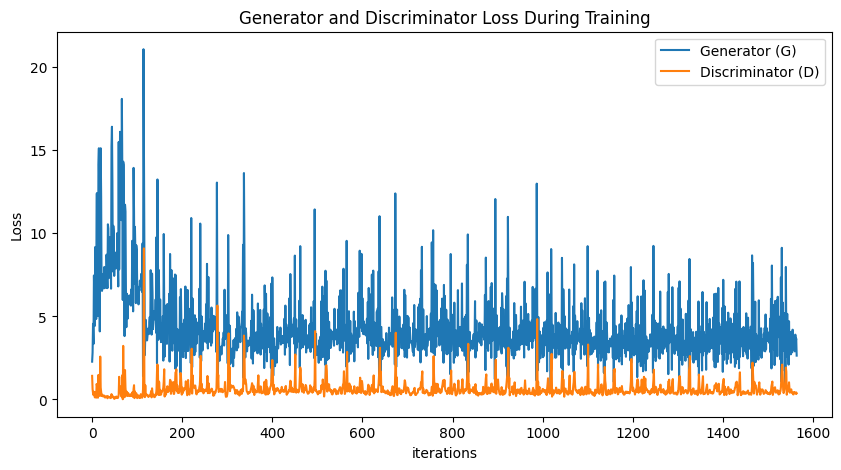

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="Generator (G)")
plt.plot(D_losses,label="Discriminator (D)")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## ✨ Conditional Generation

Now that training is complete, we can use our generator to create new, unique faces by providing it with random noise and our desired set of attributes.

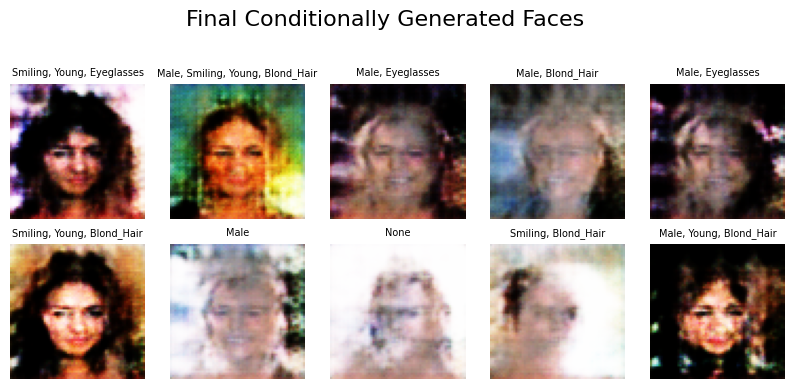

In [18]:
# Generate a smaller grid first to test
rows, cols = 2, 5  # Same as training
sample_noise = torch.randn(rows*cols, Z).to(device)
sample_conditions = torch.randint(0, 2, (rows*cols, NUM_ATTRIBUTES), dtype=torch.long).to(device)

with torch.no_grad():
    generations = generator(sample_noise, sample_conditions).cpu()
    generations = (generations + 1) / 2

display_image_grid(generations, sample_conditions.cpu(), rows, cols, "Final Conditionally Generated Faces")

### 🤔 Discussion

The results show that the cGAN is capable of generating realistic faces that often reflect the requested attributes. For example, images conditioned on 'Blond_Hair' tend to have lighter hair, and those conditioned on 'Smiling' often feature a smile. The model isn't perfect, and sometimes the attributes are subtle or mixed, but the conditioning clearly influences the output.

Challenges with cGANs are similar to standard GANs:
- **Training Instability**: The balance between the generator and discriminator is still delicate.
- **Mode Collapse**: The generator might still produce a limited variety of faces for a given condition.
- **Attribute Entanglement**: The model might learn spurious correlations in the data (e.g., associating lipstick with being 'Female', even if not explicitly told to). The quality of the dataset's labels is crucial.

Despite these challenges, cGANs are a powerful tool for controllable generation and form the basis for many advanced models like StyleGAN and image-to-image translation networks.

## 🧪 What to Try Next

- **Train for Longer**: Increasing the number of epochs can significantly improve the quality and coherence of the generated images.
- **Explore Attribute Combinations**: Generate images with specific, interesting attribute combinations. What does a 'Male, Smiling, Blond_Hair, Eyeglasses' face look like according to the model?
- **Latent Space Interpolation**: Create two noise vectors, `z1` and `z2`, and a fixed attribute vector `y`. Interpolate between `z1` and `z2` and see how the generated face changes while keeping the attributes constant.
- **Attribute Interpolation**: Fix the noise vector `z` but interpolate between two different attribute vectors, `y1` and `y2`. For example, morph a non-smiling face into a smiling one.

### Contributed by: Ali Habibullah.
